In [3]:
from __future__ import print_function

%matplotlib notebook 

import sys
import tensorflow as tf
import numpy as np

from os.path import join
from helper_functions import *
from visualization import Visualization
from sklearn.model_selection import train_test_split

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

LEARNING_RATE = 5e-5
EPOCHS = 40000
BATCH_SIZE= 256
feed_forward_neurons = 1024
kernel_size = 5
kernel_count = 32

"""Train a convolutional network with `data` and optional `filter_type` parameter."""
# def initialize(self, filter_type='original', EPOCHS=40000, LEARNING_RATE=1e-4, BATCH_SIZE=256, feed_forward_neurons=512, kernel_count=(32, 64), kernel_size = 5, model_path = "/tmp/model.ckpt" ):
#     EPOCHS = EPOCHS
#     LEARNING_RATE = LEARNING_RATE
#     BATCH_SIZE = BATCH_SIZE
#     # Model path from parameters
#     kernel_size= kernel_size
#     kernel_count_1, kernel_count_2 = kernel_count
#     feed_forward_neurons = feed_forward_neurons
model_path = 'MNIST' + str(BATCH_SIZE) + '-' + str(kernel_count) + '-' + str(kernel_size) + '-' + str(feed_forward_neurons) + '-' + 'model.ckpt'

def train_network():
    '''Train the network.'''
    viz = Visualization(steps=EPOCHS)
    print("Network initialized: ", model_path)

    x_test = mnist.test.images
    y_test = mnist.test.labels
    
    # Explicitly initialize graph
    tf.reset_default_graph()

    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Initialize input and target tensors
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, 784], name='x-input')
        y_ = tf.placeholder(tf.float32, shape=[None, 10], name='y-input')
        tf.add_to_collection('x-input', x)
        tf.add_to_collection('y-input', y_)

    # Initialize weight and bias tensors
    with tf.name_scope('convolutional_layer_1'):
        W_conv1 = weight_variable([kernel_size, kernel_size, 1, kernel_count])
        b_conv1 = bias_variable([kernel_count])

    with tf.name_scope('input_reshape'):
        x_image = tf.reshape(x, [-1,28,28,1])
        tf.summary.image('input', x_image, 10)

    with tf.name_scope('convolutional_layer_1'):
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

    with tf.name_scope('pooling_layer_1'):
        h_pool1 = max_pool_2x2(h_conv1)

    with tf.name_scope('convolutional_layer_2'):
        W_conv2 = weight_variable([kernel_size, kernel_size, kernel_count, kernel_count*2])
        b_conv2 = bias_variable([kernel_count * 2])        
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

    with tf.name_scope('pooling_layer_2'):
        h_pool2 = max_pool_2x2(h_conv2)

    with tf.name_scope('fully_connected_layer_1'):
        W_fc1 = weight_variable([7 * 7 * kernel_count * 2, feed_forward_neurons])
        b_fc1 = bias_variable([feed_forward_neurons])
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7 * kernel_count * 2])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        learning_rate = tf.placeholder(tf.float32, name='learning-rate')
        tf.add_to_collection('keep_prob', keep_prob)
        tf.summary.scalar('dropout_keep_probability', keep_prob)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)                    

    with tf.name_scope('fully_connected_layer_2'):
        W_fc2 = weight_variable([feed_forward_neurons, 64])
        b_fc2 = bias_variable([64])        
#         y_conv1 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
#         tf.add_to_collection("y_conv1", y_conv1)
        
    with tf.name_scope('fully_connected_layer_3'):
        W_fc3 = weight_variable([64, 64])
        b_fc3 = bias_variable([64])        
        h_fc3 = tf.nn.relu(tf.matmul(h_fc2, W_fc3) + b_fc3)
#         tf.add_to_collection("y_conv1", y_conv1)
        
    with tf.name_scope('dropout'):    
        h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob) 
        
    with tf.name_scope('fully_connected_layer_4'):
        W_fc4 = weight_variable([64, 128])
        b_fc4 = bias_variable([128])        
        h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)
#         tf.add_to_collection("y_conv1", y_conv1)

    with tf.name_scope('dropout2'):
#         tf.add_to_collection('keep_prob', keep_prob)
        tf.summary.scalar('dropout_keep_probability2', keep_prob)
        h_fc2_drop2 = tf.nn.dropout(h_fc4, keep_prob)      

    with tf.name_scope('fully_connected_layer_5'):        
        W_fc5 = weight_variable([128, 10])
        b_fc5 = bias_variable([10])
        y_conv = tf.matmul(h_fc2_drop2, W_fc5) + b_fc5
        tf.add_to_collection("y_conv", y_conv)

    with tf.name_scope('cross_entropy'):
        # The raw formulation of cross-entropy,
        #
        # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
        #                               reduction_indices=[1]))
        #
        # can be numerically unstable.
        #
        # So here we use tf.nn.softmax_cross_entropy_with_logits on the
        # raw outputs of the nn_layer above, and then average across
        # the batch.
        diff = tf.nn.softmax_cross_entropy_with_logits(y_conv, y_)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)

    tf.summary.scalar('cross_entropy', cross_entropy)
    tf.add_to_collection('cross_entropy', cross_entropy)

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(5e-4).minimize(cross_entropy, global_step=global_step)
        tf.add_to_collection('train_op', train_step)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
            tf.add_to_collection('correct_prediction', correct_prediction)
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            tf.add_to_collection('accuracy', accuracy)
    tf.summary.scalar('accuracy', accuracy)

    # Add an op to initialize the variables.
    init_op = tf.global_variables_initializer()

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    with tf.Session() as sess:
        # Initialize variables
        sess.run(init_op)

        # Merge all the summaries and write them out to `./logs`
        dir_path = os.path.abspath('')
        log_dir=join(dir_path,'MNISTlogs-' + str(BATCH_SIZE) + '-' + str(kernel_count) + '-' +str(kernel_size) + '-' + str(feed_forward_neurons))        
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(join(log_dir,'train'),
                                      sess.graph)
        test_writer = tf.summary.FileWriter(join(log_dir,'test'))

        # Set target test accuracy for save benchmarking
        best_accuracy = 0.90
        # Create index of test accuracy for comparison
        accuracies = []

        try:
            for epoch in range(EPOCHS):
                batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
#                     batch_x, batch_y = next_batch(BATCH_SIZE)    
                summary, _, acc, cross_entropy_loss = sess.run([merged, train_step, accuracy, cross_entropy], feed_dict={x : batch_x, y_ : batch_y, keep_prob: 0.5, learning_rate: LEARNING_RATE})

                if epoch % 100 == 99: # Record train set summaries, and test                
                    run_metadata = tf.RunMetadata()
                    train_writer.add_run_metadata(run_metadata, 'step%03d' % epoch)

                    # Add training summary
                    train_writer.add_summary(summary, epoch)

                    feed_dict = {
                        x : x_test, 
                        y_ : y_test, 
                        keep_prob: 1.0, 
                        learning_rate: LEARNING_RATE
                    }
                    summary, test_accuracy, cross_entropy_loss = sess.run([merged, accuracy, cross_entropy], feed_dict)
                    print("step %d, test accuracy %g"%(epoch, test_accuracy))
                    with open("MNIST.txt", "a") as myfile:
                        myfile.write("test_accuracy: {}, i: {}{}".format(test_accuracy,epoch,model_path))
                    viz(epoch, test=test_accuracy, cross_entropy=cross_entropy_loss)
                    test_writer.add_summary(summary, epoch)
                    if test_accuracy > best_accuracy:
                        best_accuracy = test_accuracy
                        # Save model weights to disk
                        save_path = saver.save(sess, model_path)
                        print("Model saved in file: %s" % save_path)
                        accuracies.append(test_accuracy)
                    if test_accuracy >= 0.9998: # Go to next model                            
                        print("Model completed, Epochs: ", epochs, " Test accuracy: ", test_accuracy)
                        break

                # Visualize training progress every 25 steps
                if epoch < 500 and epoch % 25 == 0:                            
                    print("step %d, training accuracy %g"%(epoch, acc))
                    viz(epoch, train=acc, cross_entropy=cross_entropy_loss)
                elif epoch % 100 == 0:
                    print("step %d, training accuracy %g"%(epoch, acc))
                    viz(epoch, train=acc, cross_entropy=cross_entropy_loss)

        finally:
            # Save model weights to disk at the end
            save_path = saver.save(sess, model_path + '-final')
            print("Model saved in file: %s" % save_path)
            train_writer.close()
            test_writer.close()
        

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<IPython.core.display.Javascript object>


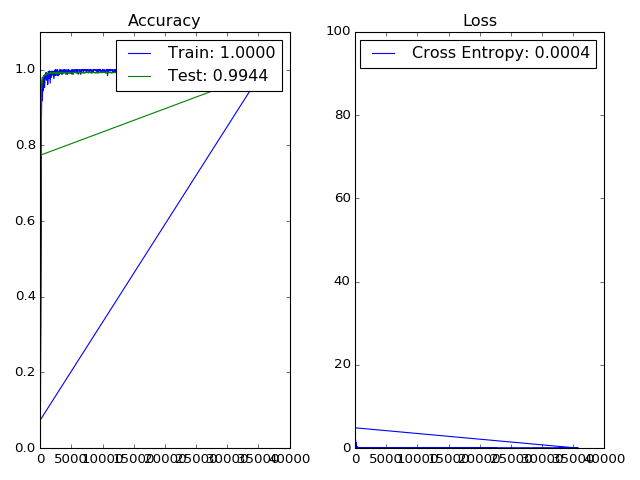

Network initialized:  MNIST256-32-5-1024-model.ckpt
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.concat_v2().
step 0, training accuracy 0.0742188
step 25, training accuracy 0.160156
step 50, training accuracy 0.253906
step 75, training accuracy 0.410156
step 99, test accuracy 0.7747
step 100, training accuracy 0.511719
step 125, training accuracy 0.675781
step 150, training accuracy 0.800781
step 175, training accuracy 0.804688
step 199, test accuracy 0.9588
Model saved in file: MNIST256-32-5-1024-model.ckpt
step 200, training accuracy 0.863281
step 225, training accuracy 0.9375
step 250, training accuracy 0.933594
step 275, training accuracy 0.925781
step 299, test accuracy 0.9733
Model saved in file: MNIST256-32-5-1024-model.ckpt
step 300, training accuracy 0.941406
step 325, training accuracy 0.957031
step 350, training

In [ ]:
train_network()